In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from Backtesting import *

In [3]:
directory = "O:/AARM/Direct/Top Holdings/Research/Biotech/NW/"

bt_data = BacktesterData(
    holdings_path=directory + 'Output/holdings.csv',
    sec_master_path=directory + 'Output/security_master.csv',
    sec_mapping_path=directory + 'Output/security_mapping.csv',
    sec_out_path=directory + 'Output/security_out.csv',
    managers_path=directory + 'Input/managers.xlsx'
)

In [4]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
bt = FilingBacktester(bt_data)


In [5]:
test_fund = "RA"
test_holdings = bt.get_fund_holdings(test_fund, eligible_securities=False)

test_holdings_long = test_holdings.reset_index().melt(
    id_vars='holding_date',
    var_name='Ticker',
    value_name='Weight'
).query('Weight > 0').sort_values(['holding_date', 'Weight'], ascending=[True, False])  # Sort by date then by weight descending

# Copy to clipboard
test_holdings_long.to_clipboard()

In [7]:
returns, attr, weights = bt.get_strategy_returns(test_holdings, end_date=pd.Timestamp('2025-05-15'))
returns.to_clipboard()

In [8]:
consolidated_error_df = bt_data.error_df.groupby(['Ticker', 'Name']).agg({
    'holding_date': ['min', 'max'],
    'value': 'sum',
    'Min_Px_Date': 'min',
    'Max_Px_Date': 'max'
}).reset_index()
consolidated_error_df.columns = ['Ticker', 'Name', 'min_holding_date', 'max_holding_date', 'value', 'Min_Px_Date', 'Max_Px_Date']
consolidated_error_df = consolidated_error_df.sort_values('value', ascending=False)

# Exclude securities I have already verified are from erroneus filings
excluded_tickers = ['SVA US', #Private, reported holdings values are stale
                    'DCPH US', #Acquired
                    'BLU CN', #Acquired
                    'ZGNX US', #Acquired
                    '1284849DUS', #Acquired
                    'ALPN US', #Acquired
                    'PRXL US', #Delisted
                    'QP/ LN', #Private
                    ]
consolidated_error_df = consolidated_error_df[~consolidated_error_df['Ticker'].isin(excluded_tickers)]

print("Top errors by value:")
# Set display options to show more rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
print(consolidated_error_df)

Top errors by value:
                   Ticker                                          Name min_holding_date max_holding_date      value Min_Px_Date Max_Px_Date
58                VYNE US                        VYNE Therapeutics Inc.       2014-12-31       2017-12-31  661.76392  2018-01-24  2025-05-15
0   #N/A Invalid Security                                    IMARA Inc.       2020-03-31       2022-12-31  482.67947         NaT         NaT
35                NEUP US                   Neuphoria Therapeutics Inc.       2017-06-30       2021-09-30  226.42897  2021-12-15  2025-05-15
60                ZCOR US                            Zyla Life Sciences       2014-12-31       2018-12-31  114.06768  2019-03-21  2020-05-18
3              1891847DUS                 Centrexion Therapeutics Corp.       2018-03-31       2024-12-31   95.24072         NaT         NaT
56                VRNA US                             Verona Pharma plc       2014-12-31       2017-03-31   92.45430  2017-04-26  202

In [9]:
mkt_cap = bt.sec_mkt_cap_df
eligible = bt.eligible_securities_df
rets = bt.sec_rets_df
valid_rets = (rets == 0).sum(axis=1) < 0.9*len(rets.columns)
mkt_cap = mkt_cap.multiply(eligible)
mkt_cap = mkt_cap.replace(0, np.nan)
mkt_cap = mkt_cap.loc[valid_rets]
rets = rets.loc[valid_rets]

# Size
size_score = np.log(mkt_cap)
size_score = bt.standardize_factor_scores(size_score).shift(1)

# Separate Reversal (short-term) and Momentum (long-term) factors
MOMENTUM_LONG_PERIOD = 252 #~1 year
REVERSAL_PERIOD = 21 #~1 month

# Long-term momentum component
# Calculate returns excluding the most recent REVERSAL_PERIOD (21 days)
# and including only the period from t-MOMENTUM_LONG_PERIOD to t-REVERSAL_PERIOD
momentum_score = np.log(rets+1).shift(REVERSAL_PERIOD).rolling(window=MOMENTUM_LONG_PERIOD-REVERSAL_PERIOD, min_periods=63).mean().fillna(0)
momentum_score = bt.standardize_factor_scores(momentum_score).shift(1)

# Short-term reversal component (negative of short-term returns)
reversal_score = -np.log(rets+1).ewm(halflife=REVERSAL_PERIOD, adjust=True).mean().fillna(0)
reversal_score = bt.standardize_factor_scores(reversal_score).shift(1)

factor_scores = {'Size': size_score, 'Momentum': momentum_score, 'Reversal': reversal_score}
factor_rets = bt.get_factor_returns(factor_scores)

Error fitting model for 2010-01-05 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-06 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-07 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-08 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-11 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-12 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-13 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-14 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-15 00:00:00: zero-size array to reduction operation maxi

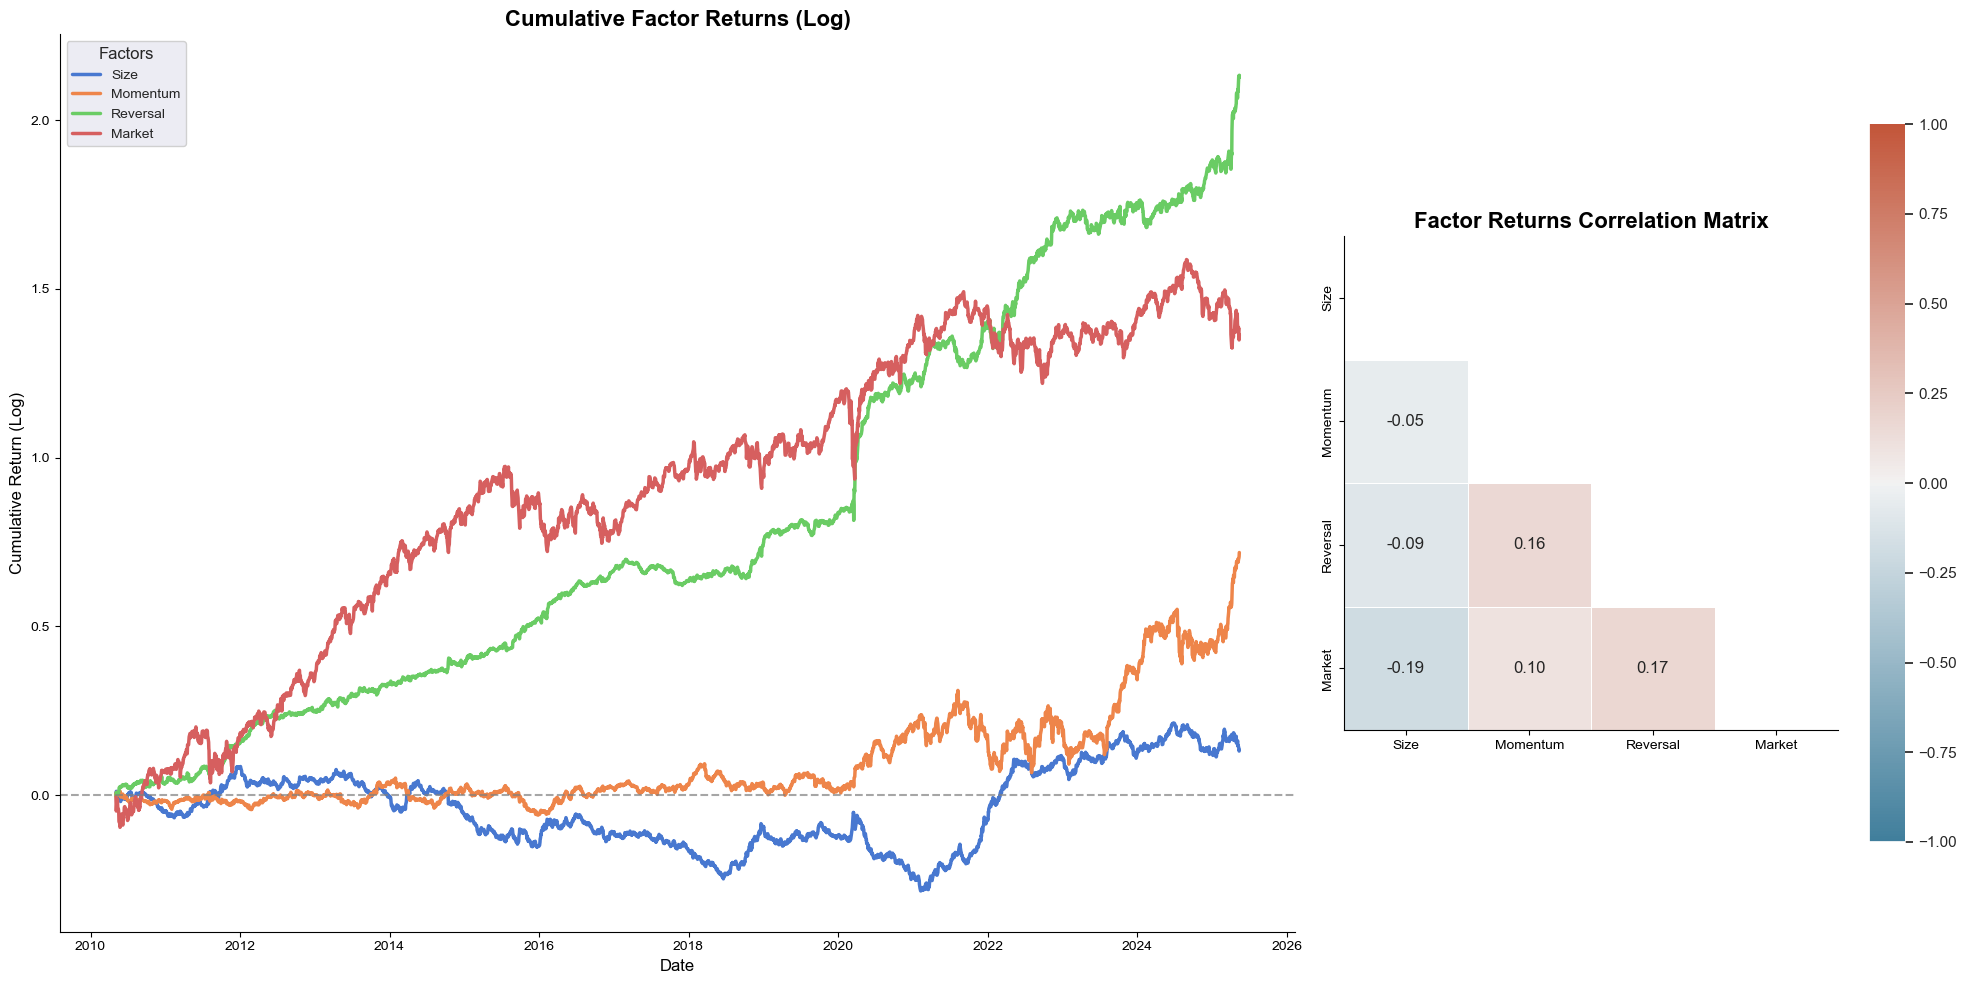

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

factor_rets_filtered = factor_rets.dropna(how='all')
factor_rets_clean = factor_rets_filtered.fillna(0)
cum_factor_rets = np.log(1 + factor_rets_clean).cumsum()

# Create a figure with side-by-side subplots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Set the seaborn style
sns.set_theme(style="darkgrid")

# Plot 1: Cumulative Factor Returns
sns.lineplot(data=cum_factor_rets, dashes=False, linewidth=2.5, palette="muted", ax=ax1)

# Enhance the plot with better formatting
ax1.set_title('Cumulative Factor Returns (Log)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Cumulative Return (Log)', fontsize=12)
ax1.legend(title='Factors', title_fontsize=12, fontsize=10, frameon=True, framealpha=0.9)

# Add a zero line for reference
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Plot 2: Factor Return Correlations
corr_matrix = factor_rets_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax2)

ax2.set_title('Factor Returns Correlation Matrix', fontsize=16, fontweight='bold')

# Format the plots
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()

Acuta
ADAR1
Affinity
Allostery
Ally Bridge
Armistice
Portfolio size was: 10000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2015-02-14, Max Portfolio Capacity: 9882677.290000
  Date: 2015-05-15, Max Portfolio Capacity: 7860811.730880
  Date: 2016-05-15, Max Portfolio Capacity: 8070407.690360
Avidity
Portfolio size was: 10000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2020-02-14, Max Portfolio Capacity: 8367671.392850
  Date: 2020-05-15, Max Portfolio Capacity: 6395278.727262
  Date: 2020-08-14, Max Portfolio Capacity: 7785534.071219
  Date: 2020-11-14, Max Portfolio Capacity: 6468905.497115
  Date: 2021-02-14, Max Portfolio Capacity: 8120640.292777
  Date: 2021-05-15, Max Portfolio Capacity: 7875161.655617
  Date: 2021-08-14, Max Portfolio Capacity: 7479609.923637
  Date: 2021-11-14, Max Portfolio Capacity: 7546509.954474
  Date: 2022-02-14, Max Portfolio Capacity: 7945449.685409
  Date: 2022-05-15, Max Portfolio Capacity: 6944502.198713
  Date: 2022

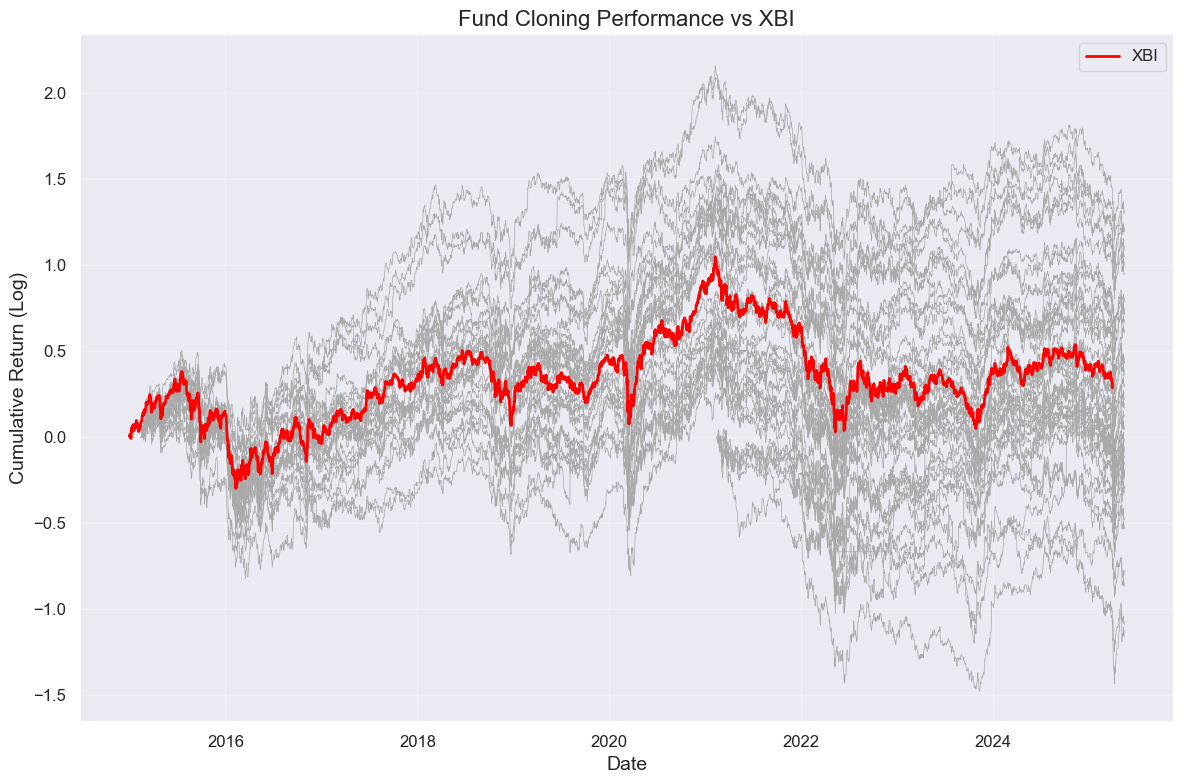

In [16]:
xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-03-31')]
xbi_cum_perf = np.log(1+xbi).cumsum()

ADD_COEF = 0 # amount to add deltas from quarter to quarter
OWNERSHIP_COEF = 0 # amount to add (ownership * weight) scaled port to existing port

# Create a dictionary to store fund performance for later reference
fund_performances = {}
fund_idio_returns = {}
fund_holdings = {}

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2024-12-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)

calendar_quarter_total_returns = bt.get_period_returns(dates=quarter_ends).shift(-1) #shift back one quarter to align with fund holdings
fund_list = bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna() | bt.manager_df['Not_Biotech'] | bt.manager_df['Contamination'])]['Master'].unique()

# Process each fund first
for fund in fund_list:
    print(fund)

    #holdings = bt.get_fund_holdings(fund, contamination = bt.manager_df.loc[bt.manager_df['Master'] == fund, 'Contamination'].values[0])
    holdings = bt.get_fund_holdings(fund)
    holdings_mv = bt.get_fund_holdings(fund, normalize=False)

    holdings_chg = holdings_mv.mul(calendar_quarter_total_returns.reindex(index=holdings.index, columns=holdings.columns) + 1).shift(1).fillna(0)
    holdings_chg = holdings_chg.div(holdings_chg.sum(axis=1), axis=0).fillna(0)
    holdings_chg = holdings.sub(holdings_chg)

    holdings_ownership = holdings_mv.div(bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns)).fillna(0)
    holdings_ownership = holdings_ownership.mul(holdings)
    holdings_ownership = holdings_ownership.div(holdings_ownership.sum(axis=1), axis=0).fillna(0)

    holdings = holdings.add(OWNERSHIP_COEF*holdings_ownership)
    holdings = holdings.add(ADD_COEF*holdings_chg).clip(lower=0)
    holdings = holdings.div(holdings.sum(axis=1), axis=0).fillna(0)

    holdings.index = holdings.index + pd.Timedelta(days=45)

    # Create mask for security criteria
    liquidity_mask = (bt.value_traded_df.reindex(index=holdings.index, columns=holdings.columns) >= 1000000)
    price_mask = (bt_data.sec_price_df.reindex(index=holdings.index, columns=holdings.columns) >= 1)
    mkt_cap_mask = (bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns) <= 25000) & (bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns) > 100)
    combined_mask = liquidity_mask & price_mask & mkt_cap_mask
    
    holdings = holdings.mul(combined_mask).fillna(0)

    fund_holdings[fund] = holdings
    
    holdings = bt.adjust_holdings(holdings, max_participation=0.2, port_size=10000000)
    
    if(len(holdings) == 0):
        print(f"{fund} has no holdings")
        continue
    
    perf, ctr, weights_df = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))
    attr = bt.get_factor_attribution(weights_df, factor_scores, factor_rets, max(holdings.index)+pd.Timedelta(days=90))

    # Store just the performance in the dictionary
    fund_performances[fund] = perf
    fund_idio_returns[fund] = attr['Idio']


# Create first figure for total performance
plt.figure(figsize=(12, 8))  # Increase figure size

# Plot each fund in light grey with no labels
for fund in fund_performances:
    perf = fund_performances[fund].fillna(0)
    cum_perf = np.log(1+perf).cumsum()
    plt.plot(cum_perf, color='darkgrey', linewidth=0.5)

# Add XBI in red with a label
plt.plot(xbi_cum_perf, color='red', linewidth=2, label='XBI')
plt.legend(fontsize=12)  # Larger legend text
plt.grid(True, alpha=0.3)
plt.title('Fund Cloning Performance vs XBI', fontsize=16)  # Larger title
plt.ylabel('Cumulative Return (Log)', fontsize=14)  # Larger y-axis label
plt.xlabel('Date', fontsize=14)  # Add and size x-axis label
plt.xticks(fontsize=12)  # Larger x-axis tick labels
plt.yticks(fontsize=12)  # Larger y-axis tick labels
plt.tight_layout()  # Adjust layout to fit larger elements
plt.show()

In [17]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

HALF_LIFE = 365*2

xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-05-15')]

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2024-12-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)
quarter_ends_delayed = [date + pd.Timedelta(days=45) for date in quarter_ends]

# Create a DataFrame to store all IR values
all_ir_data = []

for date in quarter_ends_delayed:
    for fund in fund_performances:
        if date - pd.Timedelta(days=365) not in fund_performances[fund].index or (date >= max(fund_performances[fund].index)):
            continue

        cur_fund_perf = fund_performances[fund].loc[:date]
        xbi_perf = xbi.loc[cur_fund_perf.index]
        # Join XBI performance to fund performance
        combined_perf = pd.DataFrame({
            'fund': cur_fund_perf,
            'xbi': xbi_perf
        })
        # Drop rows where either fund or XBI performance is exactly 0
        combined_perf = combined_perf[(combined_perf['fund'] != 0) & (combined_perf['xbi'] != 0)]
        # Calculate exponential weights with a half-life of 255 days
        days_diff = (date - combined_perf.index).days
        combined_perf['Weight'] = np.exp(-np.log(2) * days_diff / HALF_LIFE)

        try:
            model = sm.WLS(combined_perf['fund'], sm.add_constant(combined_perf['xbi']), weights=combined_perf['Weight'])
            results = model.fit()
        except:
            print(f"Error fitting model for {fund} on {date}")
            continue

        daily_vol = np.sqrt(np.sum(combined_perf['Weight'] * results.resid**2)/np.sum(combined_perf['Weight']))
        daily_alpha = np.sum(results.resid * combined_perf['Weight'])/np.sum(combined_perf['Weight']) + results.params.iloc[0]

        idio_perf = fund_idio_returns[fund].loc[cur_fund_perf.index]
        weighted_idio_alpha = np.sum(idio_perf * combined_perf['Weight'])/np.sum(combined_perf['Weight'])
        weighted_idio_vol = np.sqrt(np.sum((idio_perf-weighted_idio_alpha)**2 * combined_perf['Weight'])/np.sum(combined_perf['Weight']))
        
        # Add to our list of IR data
        all_ir_data.append({
            'date': date,
            'fund': fund,
            'ir': daily_alpha/daily_vol,
            'alpha': daily_alpha,
            'idio_alpha': weighted_idio_alpha,
            'idio_vol': weighted_idio_vol,
            'idio_ir': weighted_idio_alpha/weighted_idio_vol
        })

# Convert the list to a DataFrame
ir_df = pd.DataFrame(all_ir_data)

In [18]:
# Prev approach
"""
for date in ir_df['date'].unique():
    date_mask = ir_df['date'] == date
    
    ir_df.loc[date_mask, 'weight'] = ir_df.loc[date_mask, 'idio_ir']
    ir_df.loc[date_mask, 'weight'] = ir_df.loc[date_mask, 'weight'] / ir_df.loc[date_mask, 'weight'].sum()
    #allow for negative weights (virtual shorting of funds with negative IR)

# Median approach
for date in ir_df['date'].unique():
    date_mask = ir_df['date'] == date
    
    # Get the median idio_ir for this date
    median_ir = ir_df.loc[date_mask, 'idio_ir'].median()
    # Set weights equal to idio_ir
    ir_df.loc[date_mask, 'weight'] = ir_df.loc[date_mask, 'idio_ir']
    
    # Set weights to 0 for funds below median
    below_median_mask = (date_mask) & (ir_df['idio_ir'] < median_ir)
    ir_df.loc[below_median_mask, 'weight'] = 0
    
    # Normalize weights to sum to 1
    total_weight = ir_df.loc[date_mask, 'weight'].sum()
    if total_weight > 0:  # Avoid division by zero
        ir_df.loc[date_mask, 'weight'] = ir_df.loc[date_mask, 'weight'] / total_weight
"""

# Equal weight top 10 idio IR funds
for date in ir_df['date'].unique():
    date_mask = ir_df['date'] == date
    # Get top 10 funds by idio_ir for this date
    top_10_funds = ir_df[date_mask].nlargest(10, 'idio_ir')
    
    # Set all weights to 0 initially
    ir_df.loc[date_mask, 'weight'] = 0
    
    # Set equal weights for top 10 funds
    ir_df.loc[top_10_funds.index, 'weight'] = 1/10


# Create a blank DataFrame with all securities from sec_rets_df and all dates from ir_df
all_dates = ir_df['date'].unique()
all_securities = bt.sec_rets_df.columns.tolist()
final_holdings = pd.DataFrame(0.0, index=all_dates, columns=all_securities)

for date in all_dates:
    # Get the funds and their weights for that date
    funds_on_date = ir_df[ir_df['date'] == date]
    for fund, weight in zip(funds_on_date['fund'], funds_on_date['weight']):
        # Only add values for columns that exist in both DataFrames
        try:
            columns = fund_holdings[fund].columns
            final_holdings.loc[date, columns] += (fund_holdings[fund].loc[date, columns])*weight
        except KeyError:
            print(f"Skipping {fund} for date {date} - no holdings data available")
            continue

final_holdings[final_holdings < 0] = 0

# Renormalize by dividing each row by its sum
row_sums = final_holdings.sum(axis=1)
final_holdings = final_holdings.div(row_sums, axis=0)

final_holdings = bt.adjust_holdings(final_holdings, max_participation=0.2, port_size=100000000, n=100)

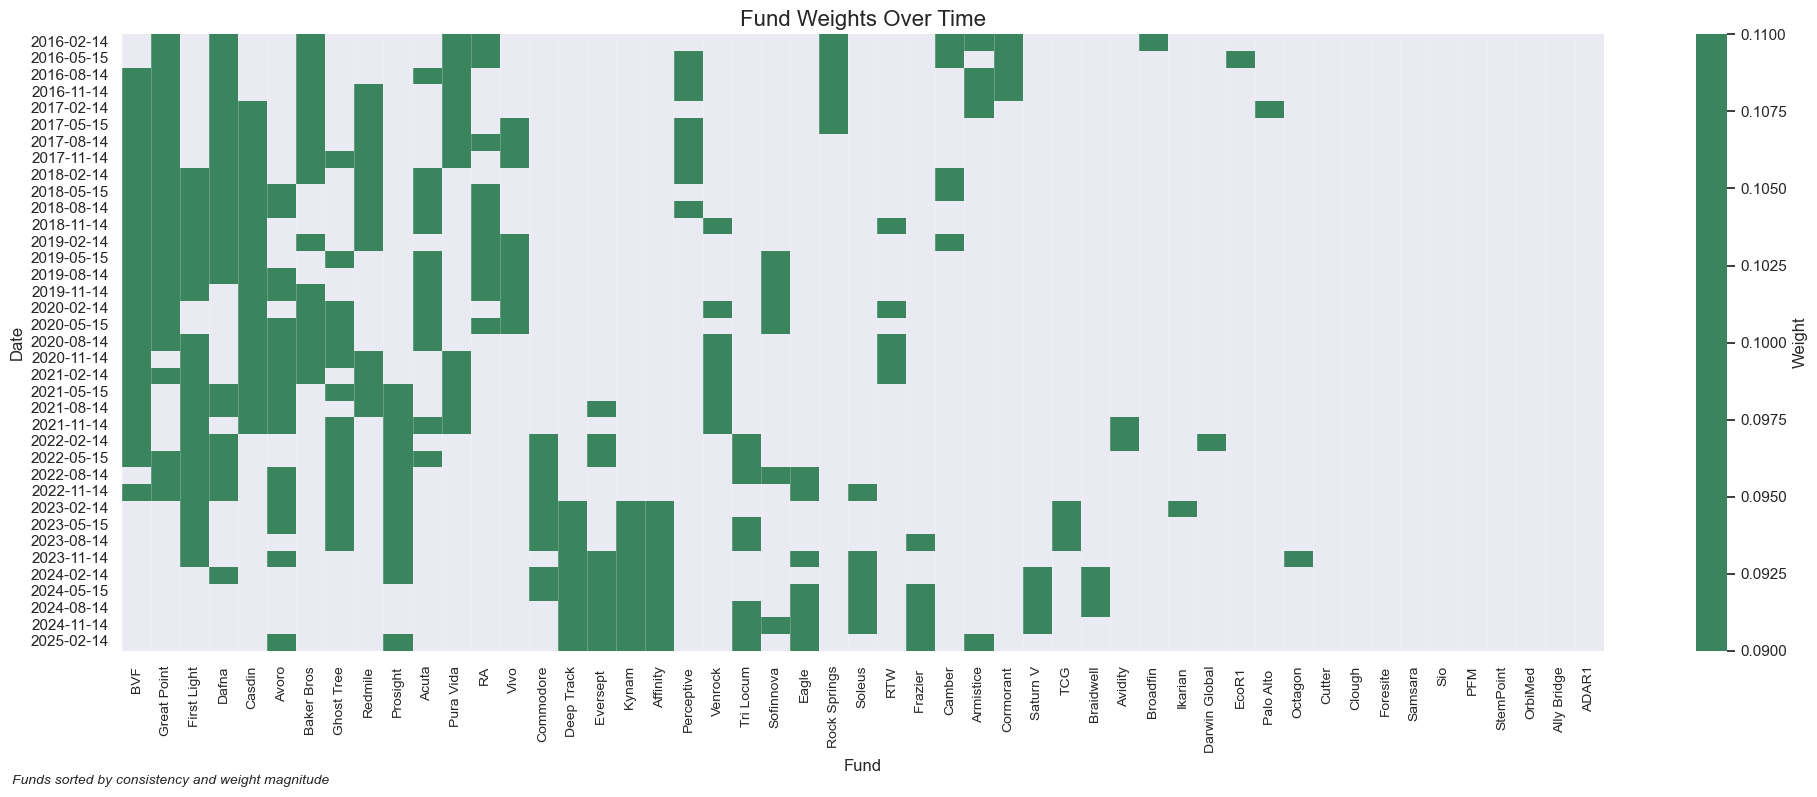

In [19]:
weight_pivot = ir_df.pivot(index='date', columns='fund', values='weight')
# Replace zeros with NaN for better visualization
weight_pivot = weight_pivot.replace(0, np.nan)

# Calculate the sum of weights over all time for each fund
fund_weight_sums = weight_pivot.sum()

# Sort funds by their total weight sum over all time
sorted_funds = fund_weight_sums.sort_values(ascending=False).index
weight_pivot = weight_pivot[sorted_funds]

# Create a diverging colormap centered at 0 with green for positive and red for negative
custom_cmap = sns.diverging_palette(10, 145, as_cmap=True)  # Changed order to make green positive

# Plot - Regular weights with increased width to show all funds
plt.figure(figsize=(20, 8))  # Increased width from 12 to 20
ax1 = sns.heatmap(weight_pivot, cmap=custom_cmap, center=0, cbar_kws={'label': 'Weight'})

plt.title('Fund Weights Over Time', fontsize=16)
plt.xlabel('Fund', fontsize=12)
plt.ylabel('Date', fontsize=12)

# Rotate x-axis labels for better readability and ensure all are visible
plt.xticks(rotation=90, fontsize=10)
plt.tick_params(axis='x', which='major', pad=5)  # Add padding for x-axis labels

# Format dates on y-axis
date_format = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
ax1.yaxis.set_major_formatter(date_format)

# Fix the yticks issue by getting the correct number of ticks
y_locs = np.arange(len(weight_pivot.index)) + 0.5  # Center of each cell
y_labels = [d.strftime('%Y-%m-%d') for d in weight_pivot.index]
plt.yticks(y_locs, y_labels)

# Add grid lines to make it easier to track across the chart
ax1.grid(False)  # Turn off the default grid
for i in range(len(sorted_funds)):
    plt.axvline(x=i, color='white', linewidth=0.5, alpha=0.3)

# Add a descriptive annotation
plt.figtext(0.01, 0.01, "Funds sorted by consistency and weight magnitude", 
            fontsize=10, style='italic')

# Ensure all labels are visible
plt.tight_layout()
plt.show()


In [21]:
returns, ctr, weights = bt.get_strategy_returns(final_holdings, end_date = pd.Timestamp('2025-05-15'))
returns.to_clipboard()

In [22]:
# Convert final_holdings to long format with Ticker column and filter out non-positive weights
final_holdings_long = final_holdings.reset_index().melt(
    id_vars='index',
    var_name='Ticker',
    value_name='Weight'
).query('Weight > 0').sort_values(['index', 'Weight'], ascending=[True, False])  # Sort by date then by weight descending

# Copy to clipboard
final_holdings_long.to_clipboard()


In [32]:
start_date = pd.Timestamp('2025-05-11') 
end_date = start_date

init_weight = weights.loc[start_date][weights.loc[start_date] > 0]

tickers = init_weight.index.values

returns = bt.sec_rets_df[tickers].loc[start_date:end_date]
returns = (1 + returns).prod() - 1

# Create DataFrame with ticker as index and required columns
result_df = pd.DataFrame({
    'Starting Weight': init_weight,
    'Return': returns,
    'Contribution': init_weight * returns
})

# Sort by contribution
result_df = result_df.sort_values('Contribution', ascending=False)

result_df.to_clipboard()


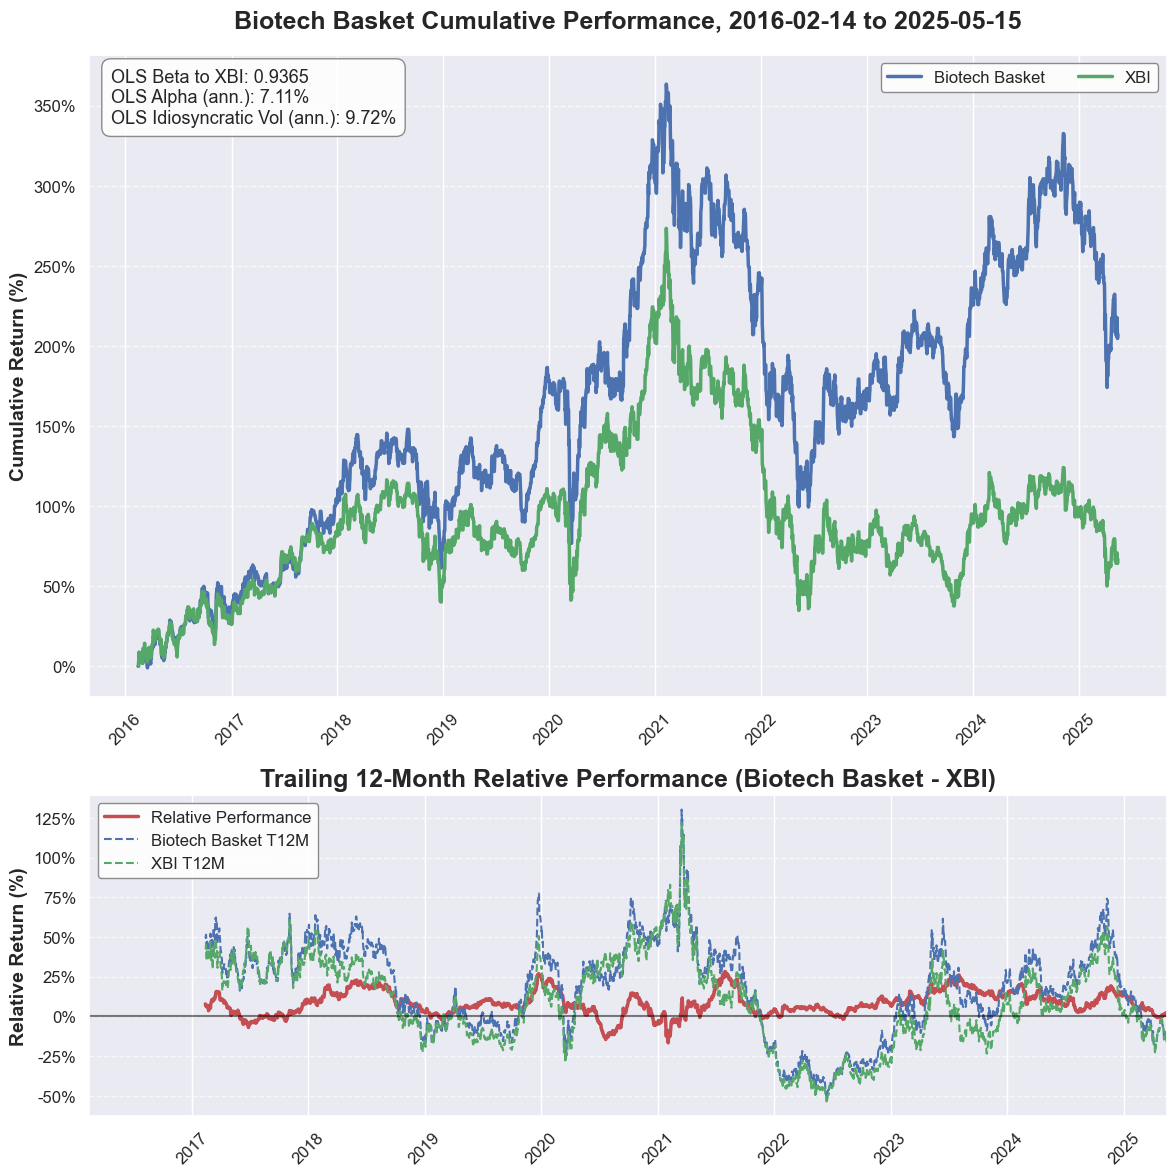

In [20]:
# Get strategy returns and XBI returns
strategy_returns, _, _ = bt.get_strategy_returns(final_holdings, pd.Timestamp('2025-05-15'))
xbi_returns = bt.sec_rets_df['XBI US'].loc[strategy_returns.index[0]:strategy_returns.index[-1]]

# Convert to cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod() - 1
xbi_cumulative = (1 + xbi_returns).cumprod() - 1

# Create a DataFrame for plotting
cumulative_returns = pd.DataFrame({
    'Biotech Basket': strategy_cumulative,
    'XBI': xbi_cumulative
})

# Calculate trailing 12-month cumulative returns for both strategy and XBI
strategy_t12m = (1 + strategy_returns).rolling(window=365).apply(lambda x: x.prod()) - 1
xbi_t12m = (1 + xbi_returns).rolling(window=365).apply(lambda x: x.prod()) - 1

# Calculate trailing 12-month relative performance (Strategy T12M - XBI T12M)
trailing_12m_relative = strategy_t12m - xbi_t12m
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute beta and alpha to XBI for regular strategy
returns_for_regression = pd.DataFrame({
    'strategy': strategy_returns,
    'xbi': xbi_returns
})
returns_for_regression = returns_for_regression.dropna()
returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                               (returns_for_regression['xbi'] != 0)]

# Add a constant to the regression model
X = sm.add_constant(returns_for_regression['xbi'])
Y = returns_for_regression['strategy']

# Fit the regression model
model = sm.OLS(Y, X).fit()
# Extract beta and alpha
beta = model.params['xbi']
alpha = model.params['const']
alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)

idio_vol = model.resid.std()
idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))
# Set a professional theme and color palette
sns.set_theme(style="ticks", palette="colorblind", font="Arial", font_scale=1.2)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Plot 1: Cumulative Performance
colors = ["#4C72B0", "#55A868"]  # Different professional colors
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=cumulative_returns, ax=ax1, linewidth=2.5, palette=colors, dashes=False)

# Format the plot
ax1.set_title(f"Biotech Basket Cumulative Performance, {cumulative_returns.index.min().strftime('%Y-%m-%d')} to {cumulative_returns.index.max().strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel("Cumulative Return (%)", fontsize=14, fontweight='bold')
ax1.set_xlabel("")  # Remove x-axis label
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Enhance legend
legend = ax1.legend(title="", loc='upper right', ncol=2, frameon=True, framealpha=0.9, 
                   fontsize=12, edgecolor='gray')
legend.get_frame().set_linewidth(1)

# Add metrics box with enhanced styling
metrics_text = (
    f"OLS Beta to XBI: {beta:.4f}\n"
    f"OLS Alpha (ann.): {alpha_annualized*100:.2f}%\n"
    f"OLS Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%"
)

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                          facecolor='white', 
                                          edgecolor='gray', 
                                          alpha=0.9,
                                          linewidth=1))

# Plot 2: Trailing 12-month Relative Performance
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=trailing_12m_relative, color="#C44E52", 
            ax=ax2, linewidth=2.5, label='Relative Performance')

# Add individual T12M returns as dotted lines
sns.lineplot(data=strategy_t12m, color="#4C72B0", ax=ax2, 
            linewidth=1.5, linestyle='--', label='Biotech Basket T12M')
sns.lineplot(data=xbi_t12m, color="#55A868", ax=ax2, 
            linewidth=1.5, linestyle='--', label='XBI T12M')

# Format the second plot
ax2.set_title("Trailing 12-Month Relative Performance (Biotech Basket - XBI)", 
             fontsize=18, fontweight='bold')
ax2.set_ylabel("Relative Return (%)", fontsize=14, fontweight='bold')
ax2.set_xlabel("")  # Remove x-axis label
ax2.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Add legend for the second plot
ax2.legend(title="", loc='upper left', ncol=1, frameon=True, framealpha=0.9, 
          fontsize=12, edgecolor='gray')

# Ensure both plots have the same x-axis range
ax2.set_xlim(cumulative_returns.index.min(), cumulative_returns.index.max())

plt.tight_layout()
plt.show()


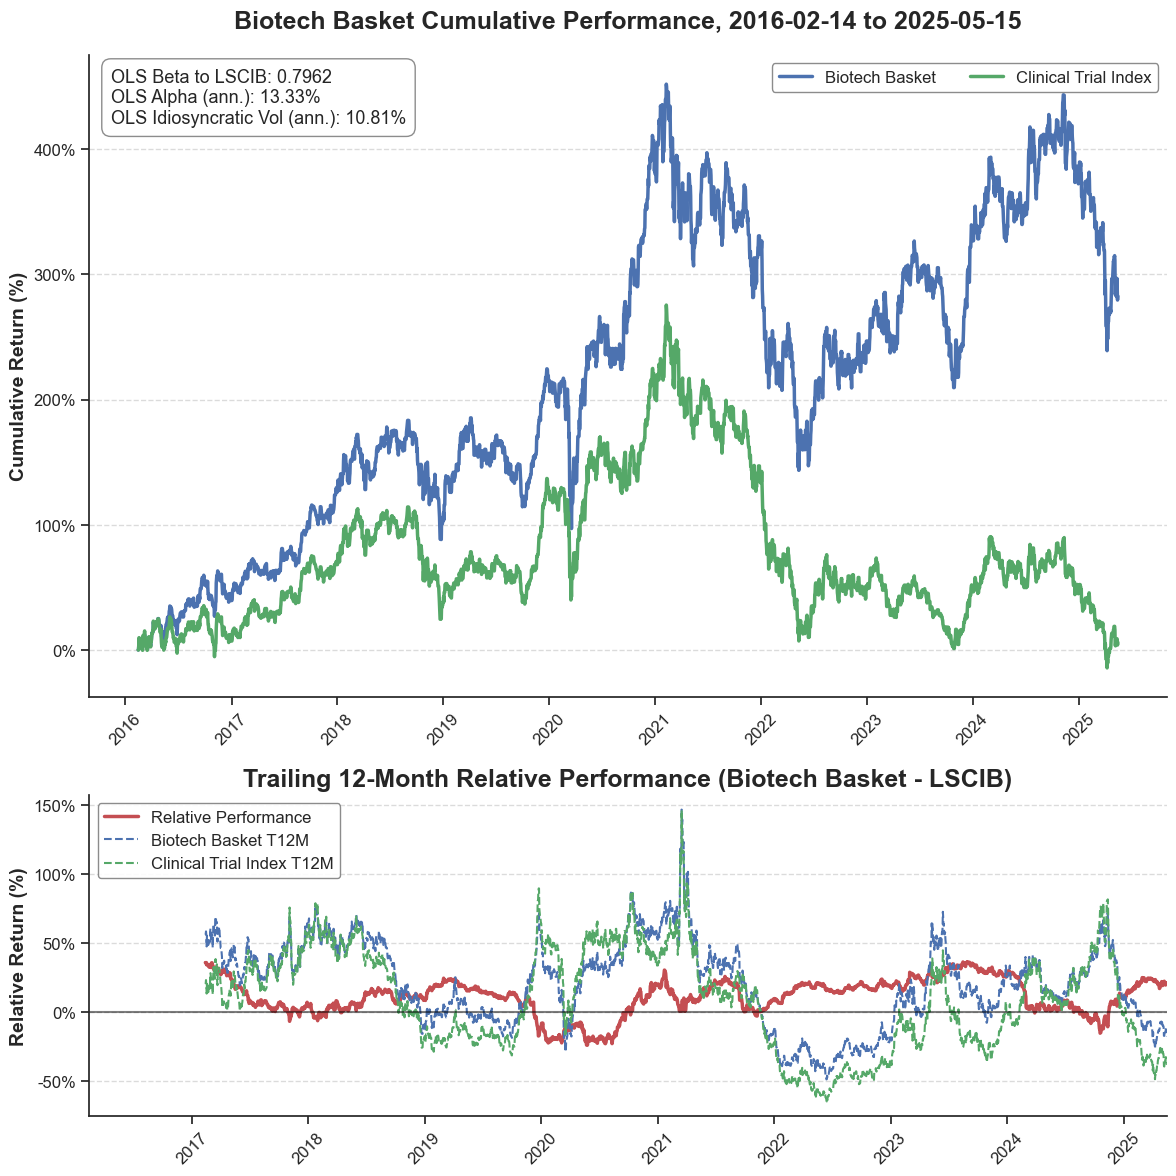

In [151]:
# Get strategy returns and LSCIBreturns
strategy_returns = bt.get_strategy_returns(final_holdings, pd.Timestamp('2025-05-15'))
clinical_trial_index_returns = bt.sec_rets_df['LSCIB'].loc[strategy_returns.index[0]:strategy_returns.index[-1]]

# Convert to cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod() - 1
clinical_trial_index_cumulative = (1 + clinical_trial_index_returns).cumprod() - 1

# Create a DataFrame for plotting
cumulative_returns = pd.DataFrame({
    'Biotech Basket': strategy_cumulative,
    'Clinical Trial Index': clinical_trial_index_cumulative
})

# Calculate trailing 12-month cumulative returns for both strategy and Clinical Trial Index
strategy_t12m = (1 + strategy_returns).rolling(window=365).apply(lambda x: x.prod()) - 1
clinical_trial_index_t12m = (1 + clinical_trial_index_returns).rolling(window=365).apply(lambda x: x.prod()) - 1

# Calculate trailing 12-month relative performance (Strategy T12M - Clinical Trial Index T12M)
trailing_12m_relative = strategy_t12m - clinical_trial_index_t12m

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute beta and alpha to LSCIB for regular strategy
returns_for_regression = pd.DataFrame({
    'strategy': strategy_returns,
    'lscib': clinical_trial_index_returns
})
returns_for_regression = returns_for_regression.dropna()
returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                               (returns_for_regression['lscib'] != 0)]

# Add a constant to the regression model
X = sm.add_constant(returns_for_regression['lscib'])
Y = returns_for_regression['strategy']

# Fit the regression model
model = sm.OLS(Y, X).fit()
# Extract beta and alpha
beta = model.params['lscib']
alpha = model.params['const']
alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)

idio_vol = model.resid.std()
idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))

# Set a professional theme and color palette
sns.set_theme(style="ticks", palette="colorblind", font="Arial", font_scale=1.2)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Plot 1: Cumulative Performance
colors = ["#4C72B0", "#55A868"]  # Different professional colors
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=cumulative_returns, ax=ax1, linewidth=2.5, palette=colors, dashes=False)

# Format the plot
ax1.set_title(f"Biotech Basket Cumulative Performance, {cumulative_returns.index.min().strftime('%Y-%m-%d')} to {cumulative_returns.index.max().strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel("Cumulative Return (%)", fontsize=14, fontweight='bold')
ax1.set_xlabel("")  # Remove x-axis label
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Enhance legend
legend = ax1.legend(title="", loc='upper right', ncol=2, frameon=True, framealpha=0.9, 
                   fontsize=12, edgecolor='gray')
legend.get_frame().set_linewidth(1)

# Add metrics box with enhanced styling
metrics_text = (
    f"OLS Beta to LSCIB: {beta:.4f}\n"
    f"OLS Alpha (ann.): {alpha_annualized*100:.2f}%\n"
    f"OLS Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%"
)

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                          facecolor='white', 
                                          edgecolor='gray', 
                                          alpha=0.9,
                                          linewidth=1))

# Plot 2: Trailing 12-month Relative Performance
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=trailing_12m_relative, color="#C44E52", 
            ax=ax2, linewidth=2.5, label='Relative Performance')

# Add individual T12M returns as dotted lines
sns.lineplot(data=strategy_t12m, color="#4C72B0", ax=ax2, 
            linewidth=1.5, linestyle='--', label='Biotech Basket T12M')
sns.lineplot(data=clinical_trial_index_t12m, color="#55A868", ax=ax2, 
            linewidth=1.5, linestyle='--', label='Clinical Trial Index T12M')

# Format the second plot
ax2.set_title("Trailing 12-Month Relative Performance (Biotech Basket - LSCIB)", 
             fontsize=18, fontweight='bold')
ax2.set_ylabel("Relative Return (%)", fontsize=14, fontweight='bold')
ax2.set_xlabel("")  # Remove x-axis label
ax2.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Add legend for the second plot
ax2.legend(title="", loc='upper left', ncol=1, frameon=True, framealpha=0.9, 
          fontsize=12, edgecolor='gray')

# Ensure both plots have the same x-axis range
ax2.set_xlim(cumulative_returns.index.min(), cumulative_returns.index.max())

plt.tight_layout()
plt.show()

In [138]:
# Get the holdings for the specified date
holdings = final_holdings.loc[pd.Timestamp('2025-02-14')].dropna().loc[lambda x: x != 0]
# Sort by size (value) in descending order
sorted_holdings = holdings.sort_values(ascending=False)
# Convert to percentage and print the sorted holdings
percentage_holdings = sorted_holdings * 100
print(percentage_holdings)

# Calculate and print average, max, and min weights across all dates
hhi = (1/(final_holdings**2).sum(axis=1))
max_weight = final_holdings.max().max() * 100
print(f"Avg Effective Concentration: {hhi.mean():.2f}")
print(f"Minimum Effective Concentration: {hhi.min():.2f}")
print(f"Average max weight: {final_holdings.max(axis=1).mean()*100:.2f}%")
print(f"Maximum weight across all dates: {max_weight:.2f}%")



NTRA US    10.868516
TEVA IT     3.359991
VERA US     3.087716
NAMS US     2.628224
INSM US     2.526043
XENE US     2.478534
PCVX US     2.446769
CNTA US     2.176927
UTHR US     2.117597
VRNA US     2.117077
MDGL US     2.058971
CRNX US     1.911673
RARE US     1.868924
AXSM US     1.843663
SRPT US     1.746198
ILMN US     1.656442
ICLR US     1.654478
ASND US     1.573007
JANX US     1.452513
SNDX US     1.413318
TARS US     1.362597
CLDX US     1.352217
MIRM US     1.332866
JAZZ US     1.312593
TWST US     1.294775
KRYS US     1.241082
ARQT US     1.190691
BMRN US     1.149690
ALKS US     1.136324
SLNO US     1.132024
CGON US     1.129961
MRUS US     1.120368
EWTX US     0.997021
BCRX US     0.953600
RYTM US     0.931684
VRDN US     0.910731
APGE US     0.908642
WVE US      0.886319
BBIO US     0.841413
STVN US     0.837504
RVTY US     0.767679
BPMC US     0.766252
APLS US     0.764778
NBIX US     0.763811
MDXG US     0.730910
KYMR US     0.718936
ACLX US     0.701670
AVDL US     0

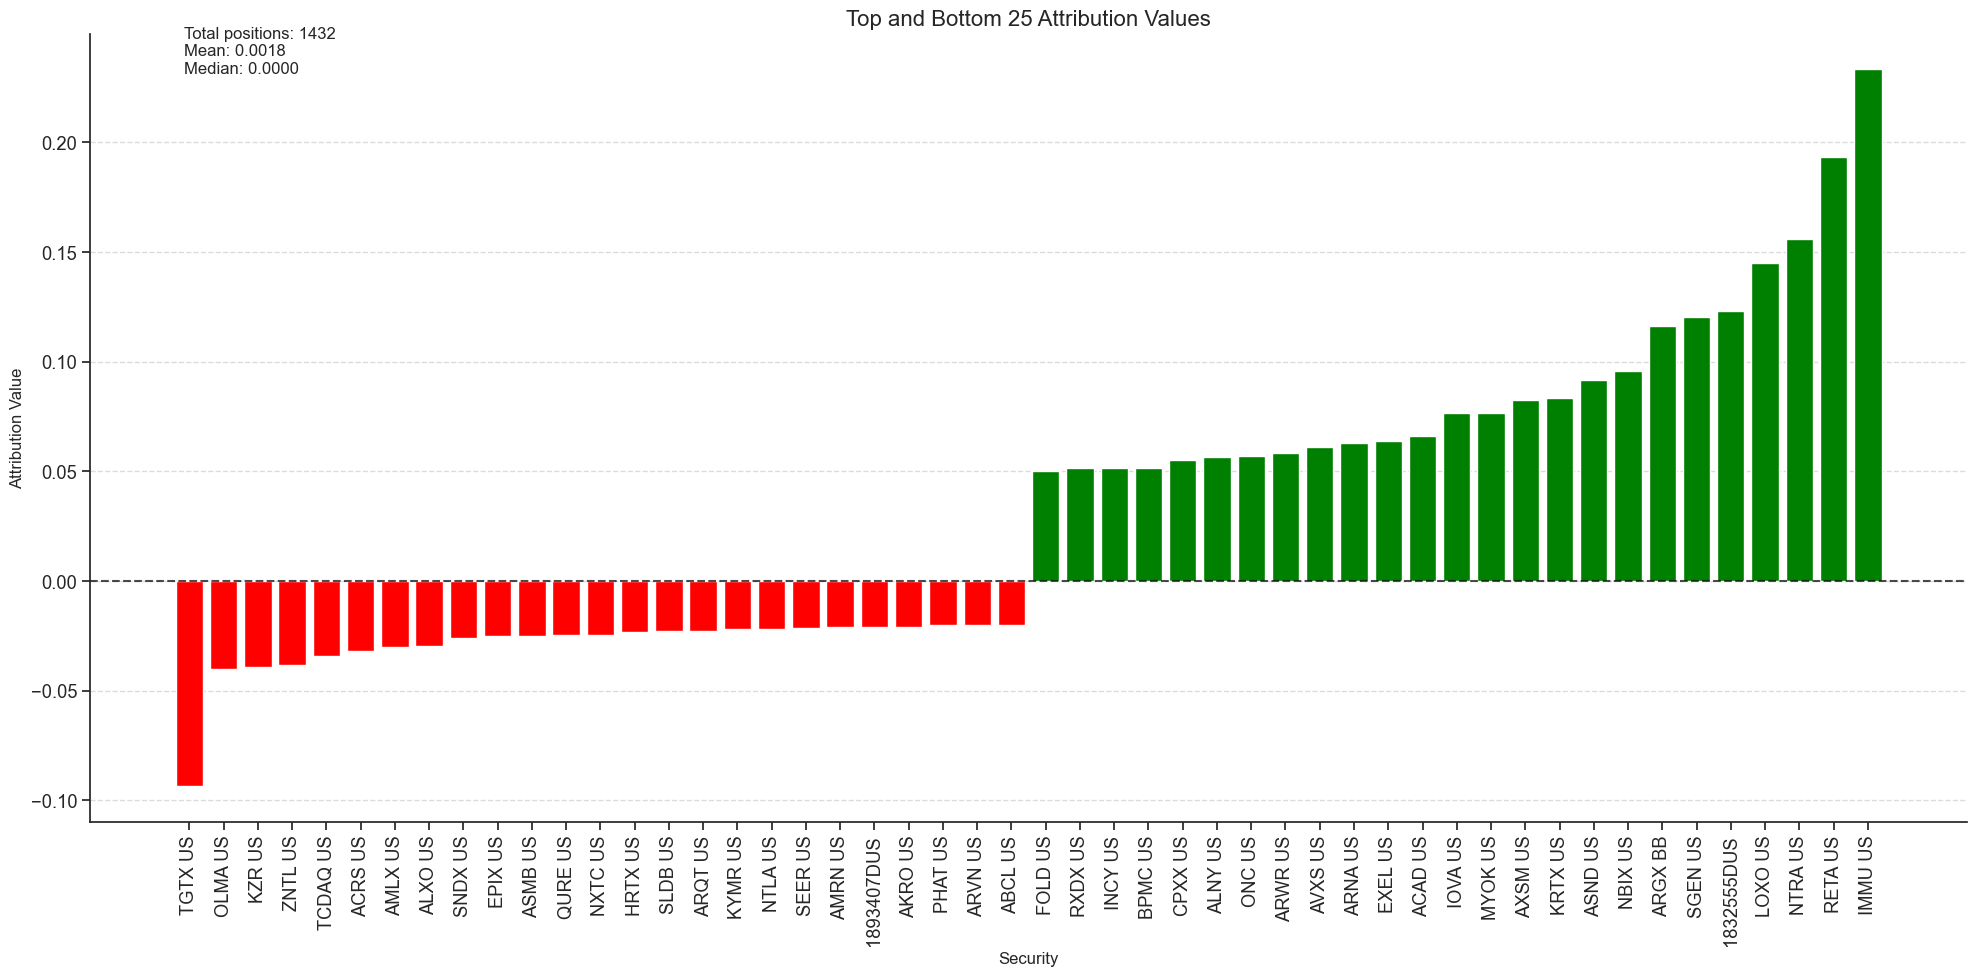

In [139]:
attr = bt.get_strategy_attribution(final_holdings, end_date=pd.Timestamp('2025-05-15'))
attr = FilingBacktester.carino_attribution(attr)

# Sort all attribution values from smallest to largest
plot_data = attr.sort_values()

# Get the bottom 25 and top 25 attributions
bottom_25 = plot_data.head(25)
top_25 = plot_data.tail(25)

# Combine them into a single dataframe for plotting
combined_data = pd.concat([bottom_25, top_25])

# Create a bar plot for the top and bottom 25 attributions with wider figure
plt.figure(figsize=(20, 10))
bars = plt.bar(combined_data.index, combined_data.values, color=['red' if x < 0 else 'green' for x in combined_data.values])

# Add labels and title
plt.title('Top and Bottom 25 Attribution Values', fontsize=16)
plt.xlabel('Security', fontsize=12)
plt.ylabel('Attribution Value', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add summary statistics as text
plt.text(0.05, 0.95, f"Total positions: {len(attr)}\nMean: {plot_data.mean():.4f}\nMedian: {plot_data.median():.4f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [140]:
factor_ctr = bt.get_factor_attribution(final_holdings, factor_scores, factor_rets, pd.Timestamp('2025-03-31'))
carino_factor_ctr = FilingBacktester.carino_attribution(factor_ctr)
print(carino_factor_ctr)
print(carino_factor_ctr.sum())
print(carino_factor_ctr/carino_factor_ctr.sum())

Size       -1.265497
Momentum    0.392366
Reversal    0.392624
Market      1.342598
Idio        1.832298
dtype: float64
2.6943887276593346
Size       -0.469679
Momentum    0.145624
Reversal    0.145719
Market      0.498294
Idio        0.680042
dtype: float64


C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_51804\1944925703.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_51804\1944925703.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


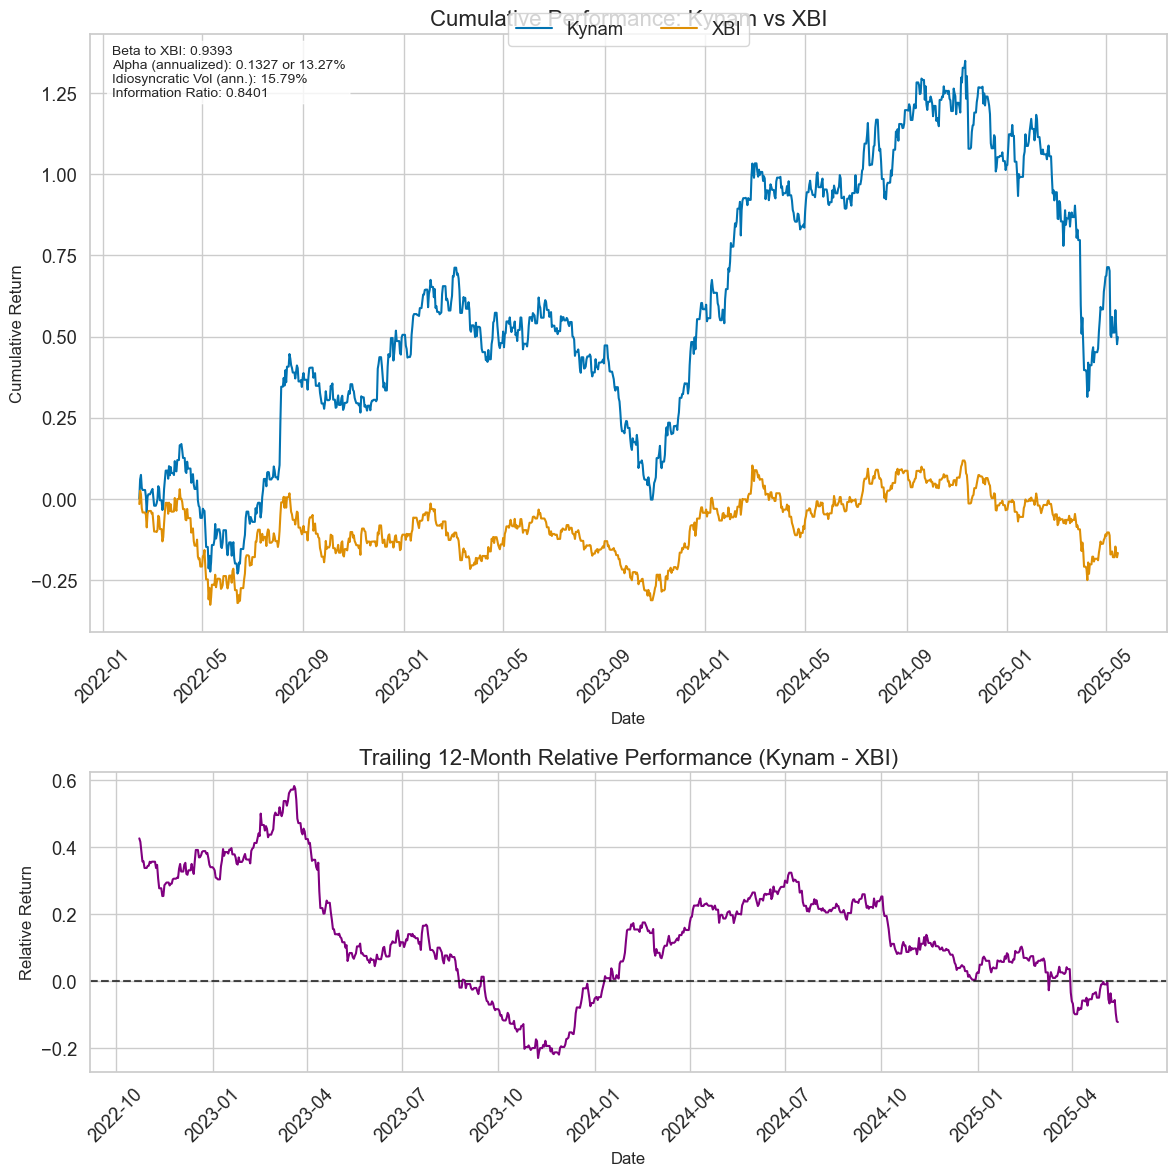

In [83]:
# Set the Master fund to analyze
master_fund = "Kynam"  # Change this to the fund you want to analyze

# Get the fund's holdings
holdings = fund_holdings[master_fund]
holdings = bt.adjust_holdings(holdings, max_participation=0.2, port_size=10000000)

perf = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))

# Get XBI returns for comparison
xbi = bt.sec_rets_df['XBI US'].loc[perf.index[0]:perf.index[-1]]
xbi_cum_perf = (1+xbi).cumprod()-1

# Replace NaN values with 0 to avoid issues in cumulative performance calculation
perf = perf.fillna(0)
cum_perf = (1+perf).cumprod()-1

# Calculate trailing 12-month relative performance
trailing_12m = pd.DataFrame({
    master_fund: perf.rolling(252).sum(),
    'XBI': xbi.rolling(252).sum()
})
trailing_12m_relative = trailing_12m[master_fund] - trailing_12m['XBI']

# Calculate regression metrics
X = sm.add_constant(xbi)
model = sm.OLS(perf, X).fit()
beta = model.params[1]
alpha = model.params[0]
alpha_annualized = alpha * 252
idio_vol = np.std(model.resid)
idio_vol_annualized = idio_vol * np.sqrt(252)
information_ratio = alpha_annualized / idio_vol_annualized

# Create a DataFrame for cumulative returns
cumulative_returns = pd.DataFrame({
    master_fund: cum_perf,
    'XBI': xbi_cum_perf
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Performance
sns.set_style("whitegrid")
sns.lineplot(data=cumulative_returns, dashes=False, ax=ax1)
ax1.set_title(f"Cumulative Performance: {master_fund} vs XBI", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cumulative Return", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Add text box with metrics to the top left corner of the main plot
metrics_text = (f"Beta to XBI: {beta:.4f}\n"
                f"Alpha (annualized): {alpha_annualized:.4f} or {alpha_annualized*100:.2f}%\n"
                f"Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%\n"
                f"Information Ratio: {information_ratio:.4f}")

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Trailing 12-month Relative Performance
sns.lineplot(data=trailing_12m_relative, color='purple', ax=ax2)
ax2.set_title(f"Trailing 12-Month Relative Performance ({master_fund} - XBI)", fontsize=16)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Relative Return", fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()